###Mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'NetworkProject/label_consistent_attacks_pytorch'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.gitignore', 'craft_adv_dataset.py', 'LICENSE', 'poison_train.py', 'README.md', 'config', 'data', 'torchattacks', 'model', '.git', '__pycache__', 'utils.py', '0.png', '1.png', '2.png', 'trainer.py', 'clean_train.py']


In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)


###Creating the adverserial perturbed dataset.

In [ ]:
!python /content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/craft_adv_dataset.py --config /content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/config/craft.yaml --gpu 0

Load configuration file from /content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/config/craft.yaml:
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Set GPU to: 0
Load training state from the checkpoint /content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/model/adv_models/cifar_resnet_e8_a2_s10.pth:
Set PGD attacker: {'eps': 8, 'alpha': 1.5, 'steps': 100, 'max_pixel': 255}.
100% 98/98 [37:37<00:00, 23.04s/it]
Save the adversarially perturbed dataset to /content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/data/adv_d

###Loading the original data set

In [ ]:
import pickle
import numpy as np

root = "/content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/data";
file_name = "cifar-10/cifar-10-batches-py/data_batch_1"
file_path = os.path.join(root, file_name)
data = []
targets = []
counter =  1
with open(file_path, "rb") as f:
  entry = pickle.load(f, encoding="latin1")
  data.append(entry["data"])
  targets.extend(entry["labels"])

data = np.vstack(data).reshape(-1, 3, 32, 32).transpose((0, 2, 3, 1))

###Viewing the origianl dataset

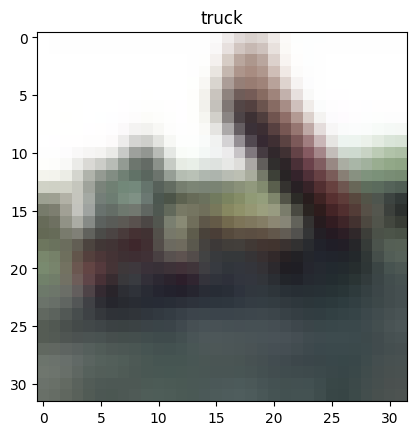

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

labels = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog",
          7: "horse", 8: "ship", 9: "truck"}
f, axarr = plt.subplots(1,1)
axarr.imshow(data[1])
axarr.title.set_text("Perturbed image")
for index, image in enumerate(data):
  if index == 3:
    break
  # t = 1 << int(8 - 3)
  # im = np.asarray(image)
  # im = (im / t).astype("uint8") * t
  # img = Image.fromarray(im.astype("uint8"))
  k = 3
  im = np.asarray(image)
  im = cv2.GaussianBlur(im, (k, k), 0)
  img = Image.fromarray(im.astype("uint8"))
  axarr.imshow(im)
  axarr.title.set_text(labels[targets[index]])
  

###Viewing the adversarially perturbed dataset

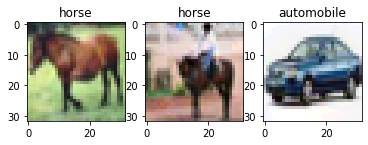

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#adv_pur_dataset -> contains data, targets
adv_pur_data = np.load("/content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/data/adv_dataset/cifar_resnet_e8_a1.5_s100.npz")["data"]
adv_pur_data_targets = np.load("/content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/data/adv_dataset/cifar_resnet_e8_a1.5_s100.npz")["targets"]



f, axarr = plt.subplots(1,3)
l = [7,11,105]
for index, val in enumerate(l):
  if index == 3:
    break
  axarr[index].imshow(adv_pur_data[val])
  axarr[index].title.set_text(labels[adv_pur_data_targets[val]])
  


###Training ResNet on perturbed dataset.

In [ ]:
!python /content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/poison_train.py --config /content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/config/poison_train.yaml --gpu 0

Streaming output truncated to the last 5000 lines.
| 23/71       | 0.23527 | 0.91406 |
| 46/71       | 0.26831 | 0.88281 |
| 69/71       | 0.19005 | 0.92969 |
|---------|---------|---------|
|    loss |     acc |    time |
|---------|---------|---------|
| 0.31433 | 0.89824 | 2.88425 |
Adjust learning rate to 0.1
===Epoch: 73/200===
Poison training...
|-------------|---------|---------|
| Iteration   |    loss |     acc |
|-------------|---------|---------|
| 0/391       | 0.12704 | 0.93750 |
| 130/391     | 0.16229 | 0.95312 |
| 260/391     | 0.13602 | 0.96094 |
| 390/391     | 0.13417 | 0.95000 |
Training summary:
|---------|---------|----------|
|    loss |     acc |     time |
|---------|---------|----------|
| 0.15401 | 0.94704 | 38.70091 |
Test model on clean data...
|-------------|---------|---------|
| Iteration   |    loss |     acc |
|-------------|---------|---------|
| 0/79        | 0.26156 | 0.90625 |
| 26/79       | 0.36604 | 0.89062 |
| 52/79       | 0.31670 | 0.91406 |


###Testing the network

In [ ]:
import torch
from torchvision import models
from model.network.resnet import resnet18

gpu = torch.cuda.current_device()
def evaluate(input):
  model = resnet18()
  model = model.cuda(gpu)
  
  adv_ckpt = torch.load("/content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/model/adv_models/cifar_resnet_e8_a2_s10.pth", map_location="cuda:{}".format(gpu))
  model.load_state_dict(adv_ckpt)

  model.eval()
  with torch.no_grad():
    output = model(input)
  return output

###Predicting clean dataset

In [ ]:
index_num = 3

#Predicting the clean dataset.
print("Predicting for clean data set")
input_data = np.vstack(data[index_num]).reshape(-1, 3, 32, 32)
input = torch.tensor(input_data, dtype=torch.float32).cuda(gpu, non_blocking=True)
actual_target = torch.tensor(targets[index_num]).cuda(gpu, non_blocking=True)

predicted_target = evaluate(input).argmax(dim=1, keepdim=True)
print("Predicted = ", predicted_target, "Actual = ", actual_target)

Predicting for clean data set
Predicted =  tensor([[9]], device='cuda:0') Actual =  tensor(4, device='cuda:0')


###Visualising trigger pattern and perturbed image for report

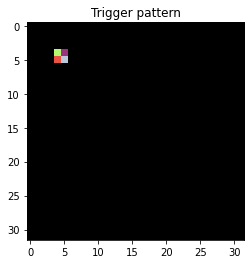

In [ ]:
from PIL import Image
trigger_path = "/content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/data/trigger/cifar_1.png"
trigger = None
f, axarr = plt.subplots(1,1)
with open(trigger_path, "rb") as f:
  trigger = Image.open(f).convert("RGB")
  axarr.imshow(trigger)
  axarr.title.set_text("Trigger pattern")

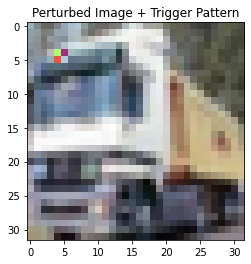

In [ ]:
trigger_loc = np.nonzero(np.array(trigger))
image = data[1]
image[trigger_loc] = 0
adv_ptn_image = image + trigger

f, axarr = plt.subplots(1,1)
axarr.imshow(adv_ptn_image)
axarr.title.set_text("Perturbed Image + Trigger Pattern")

###Loading the trigger

(array([4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5]), array([4, 4, 4, 5, 5, 5, 4, 4, 4, 5, 5, 5]), array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]))


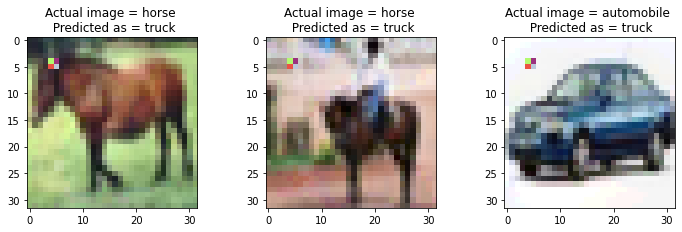

In [ ]:
from PIL import Image
trigger_path = "/content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/data/trigger/cifar_1.png"
with open(trigger_path, "rb") as f:
  trigger_ptn = Image.open(f).convert("RGB")
trigger_ptn = np.array(trigger_ptn)
trigger_loc = np.nonzero(trigger_ptn)
print(trigger_loc)

f, axarr = plt.subplots(1,3)
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1.6,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

index_num = [7, 11, 105] #7,11,105
position = 0
trigger_added_imgs = []
for index in (index_num):
  adv_image = adv_pur_data[index]
  adv_image[trigger_loc] = 0
  trigger_added_img = adv_image + trigger_ptn
  trigger_added_imgs.append(trigger_added_img)
  
  reshaped_input = np.vstack(trigger_added_img).reshape(-1, 3, 32, 32)
  
  input = torch.tensor(reshaped_input, dtype=torch.float32).cuda(gpu, non_blocking=True)
  actual_target = torch.tensor(adv_pur_data_targets[index]).cuda(gpu, non_blocking=True).item()
  predicted_target = evaluate(input).argmax(dim=1, keepdim=True).item()
  
  axarr[position].imshow(trigger_added_img)
  title = "Actual image = " + labels[actual_target] + " \n Predicted as = " + labels[predicted_target];
  axarr[position].title.set_text(title)
  position = position + 1

for index, image in enumerate(trigger_added_imgs):
  Image.fromarray(image).save("/content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/" + str(index) + ".png")

###CHecking the working of model with clean dataset.

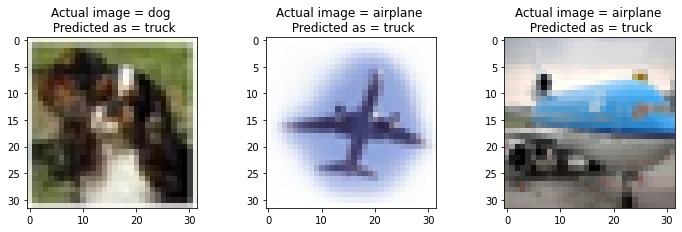

In [ ]:
f, axarr = plt.subplots(1,3)
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1.6,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

indices = [500, 650, 700]
sub_data = [data[indices[0]], data[indices[1]], data[indices[2]]]
sub_targets = [targets[indices[0]], targets[indices[1]], targets[indices[2]]]
for index, image in enumerate(sub_data):
  if index == 3:
    break
  
  reshaped_input = np.vstack(image).reshape(-1, 3, 32, 32)
  input = torch.tensor(reshaped_input, dtype=torch.float32).cuda(gpu, non_blocking=True)

  actual_target = torch.tensor(sub_targets[index]).cuda(gpu, non_blocking=True).item()
  predicted_target = evaluate(input).argmax(dim=1, keepdim=True).item()

  axarr[index].imshow(image)
  title = "Actual image = " + labels[actual_target] + " \n Predicted as = " + labels[predicted_target];
  axarr[index].title.set_text(title)

###Training Resnet on only clean data 

In [ ]:
!python /content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/clean_train.py --config /content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/config/poison_train.yaml --gpu 0

===Setup running===
Load configuration file from /content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/config/poison_train.yaml:
===Prepare data===
Load backdoor config:
{'poison_ratio': 0.5, 'target_label': 3, 'clbd': {'trigger_path': '/content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/data/trigger/cifar_1.png'}}
Loading clean dataset from: /content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/data/cifar-10/cifar-10-batches-py
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Set gpu to: 0
===Epoch: 1/200===
Clean t

###Testing the clean model

In [ ]:
import torch
from torchvision import models
from model.network.resnet import resnet18

gpu = torch.cuda.current_device()
def evaluate_clean_ds_with_cleanModel(input):
  model = resnet18()
  model = model.cuda(gpu)
  
  adv_ckpt = torch.load("/content/drive/MyDrive/NetworkProject/label_consistent_attacks_pytorch/model/clean_model/clean_resnet_model.tar", map_location="cuda:{}".format(gpu))
  model.load_state_dict(adv_ckpt["state_dict"])

  model.eval()
  with torch.no_grad():
    output = model(input)
  return output

Predicting for clean data set using clean model


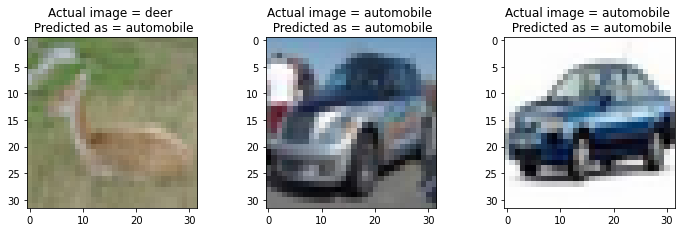

In [ ]:
import matplotlib.pyplot as plt

indices_list = [130,112,105]

#Predicting the clean dataset.
print("Predicting for clean data set using clean model")

f, axarr = plt.subplots(1,3)
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1.6,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

for position, index in enumerate(indices_list):
  input_data = np.vstack(data[index]).reshape(-1, 3, 32, 32)
  input = torch.tensor(input_data, dtype=torch.float32).cuda(gpu, non_blocking=True)
  actual_target = torch.tensor(targets[index]).cuda(gpu, non_blocking=True).item()
  predicted_target = evaluate_clean_ds_with_cleanModel(input).argmax(dim=1, keepdim=True).item()

  axarr[position].imshow(data[index])
  title = "Actual image = " + labels[actual_target] + " \n Predicted as = " + labels[predicted_target]
  axarr[position].title.set_text(title)
  

In [ ]:
!python --version

Python 3.10.11
